In [1]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
# Import necessary libraries
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import GPT2Config, GPT2Model
from tqdm import tqdm, trange
# from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup, AdamW
# Initialize the GPT-2 model and tokenizer
# tokenizer = GPT2Tokenizer.from_config(GPT2Config())
# model = GPT2LMHeadModel.from_config(GPT2Config())

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [27]:
class SepWordEmbed(nn.Module):
    def __init__(self, embed_dims=(7,10,10), embed_size=256):
        super(SepWordEmbed, self).__init__()
        self.embedding1 = nn.Embedding(embed_dims[0]+1, embed_size)
        self.embedding2 = nn.Embedding(embed_dims[1]+1, embed_size)
        self.embedding3 = nn.Embedding(embed_dims[2]+1, embed_size)

    def forward(self, attr_seq_tsr):
        # split the attr_seq_tsr into three parts along the last dimension
        # attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3 = torch.split(attr_seq_tsr, [1,1,1], dim=-1)
        attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3 = attr_seq_tsr[...,0], attr_seq_tsr[...,1], attr_seq_tsr[...,2]
        # attr_seq_embed = self.embedding1(attr_seq_tsr_1) + self.embedding2(attr_seq_tsr_2) + self.embedding3(attr_seq_tsr_3)
        attr_seq_embed = th.concat([self.embedding1(attr_seq_tsr_1), 
                                    self.embedding2(attr_seq_tsr_2), 
                                    self.embedding3(attr_seq_tsr_3)], dim=-1)
        return attr_seq_embed
    
class SepLMhead(nn.Module):
    def __init__(self, embed_dims=(7,10,10), embed_size=256):
        super(SepLMhead, self).__init__()
        self.embed_size = embed_size
        self.lmhead1 = nn.Linear(embed_size, embed_dims[0]+1)
        self.lmhead2 = nn.Linear(embed_size, embed_dims[1]+1)
        self.lmhead3 = nn.Linear(embed_size, embed_dims[2]+1)
        
    def forward(self, attr_seq_embed):
        embed1, embed2, embed3 = torch.split(attr_seq_embed, [self.embed_size,self.embed_size,self.embed_size], dim=-1)
        attr_seq_tsr_1 = self.lmhead1(embed1)
        attr_seq_tsr_2 = self.lmhead2(embed2)
        attr_seq_tsr_3 = self.lmhead3(embed3)
        return attr_seq_tsr_1, attr_seq_tsr_2, attr_seq_tsr_3
        

class MultiIdxGPT2Model(nn.Module):
    def __init__(self, attribute_dims=(7,10,10), vocab_size=0, max_length=128, n_embd=768, n_class=0, **kwargs):
        super().__init__()
        self.sep_word_embed = SepWordEmbed(attribute_dims, embed_size=n_embd//3)
        # Combine embeddings
        combined_embedding_size = n_embd  # Adjust based on your combination strategy
        config = GPT2Config(vocab_size=vocab_size, n_positions=max_length, n_embd=combined_embedding_size, **kwargs)
        # config = GPT2Config(
        #     vocab_size=27,
        #     n_positions=128,
        #     n_ctx=128,
        #     n_embd=768,
        #     n_layer=12,
        #     n_head=12,
        #     activation_function='gelu_new',
        #     resid_pdrop=0.1,
        #     embd_pdrop=0.1,
        #     attn_pdrop=0.1,
        #     layer_norm_epsilon=1e-5,
        #     initializer_range=0.02,
        #     summary_type='cls_index',
        #     summary_use_proj=True,
        #     summary_activation=None,
        #     summary_proj_to_labels=True,
        #     summary_first_dropout=0.1,
        #     bos_token_id=50256,
        #     eos_token_id=50256,
        #     gradient_checkpointing=False,
        # )
        self.gpt2 = GPT2Model(config)
        self.multi_lmhead = SepLMhead(attribute_dims, embed_size=n_embd//3)
        self.context_embed = nn.Embedding(1+n_class, n_embd)

    def forward(self, input_ids, y=None):
        # input_ids is expected to be a list of three tensors [attr1, attr2, attr3]
        if y is None:
            y = torch.zeros(input_ids.shape[0], dtype=th.long).to(input_ids[0].device)
        ctx_vec = self.context_embed(y)
        combined_embedding = self.sep_word_embed(input_ids)
        combined_embedding = torch.concat([ctx_vec[:,None,:], combined_embedding, ], dim=1)
        outputs = self.gpt2(inputs_embeds=combined_embedding)
        logits_attr1, logits_attr2, logits_attr3 = self.multi_lmhead(outputs.last_hidden_state)
        return outputs, logits_attr1, logits_attr2, logits_attr3
    

def multi_attr_loss(outputs, targets, loss_fn=F.cross_entropy, ):
    loss1 = loss_fn(outputs[0].permute(0,2,1), targets[..., 0])
    loss2 = loss_fn(outputs[1].permute(0,2,1), targets[..., 1])
    loss3 = loss_fn(outputs[2].permute(0,2,1), targets[..., 2])
    return loss1 + loss2 + loss3


def multi_attr_loss_vec(outputs, targets, loss_fn=F.cross_entropy, ):
    logits1, logits2, logits3 = outputs[0], outputs[1], outputs[2]
    loss1 = loss_fn(logits1.reshape(-1, logits1.size(-1)), targets[..., 0].view(-1))
    loss2 = loss_fn(logits2.reshape(-1, logits2.size(-1)), targets[..., 1].view(-1))
    loss3 = loss_fn(logits3.reshape(-1, logits3.size(-1)), targets[..., 2].view(-1))
    return loss1 + loss2 + loss3


def next_token_loss(outputs, targets, loss_fn=F.cross_entropy):
    logits1, logits2, logits3 = outputs[0], outputs[1], outputs[2]
    loss1 = loss_fn(logits1[:, :-1, :].permute(0,2,1), targets[:, 1:, 0])
    loss2 = loss_fn(logits2[:, :-1, :].permute(0,2,1), targets[:, 1:, 1])
    loss3 = loss_fn(logits3[:, :-1, :].permute(0,2,1), targets[:, 1:, 2])
    return loss1 + loss2 + loss3


In [3]:
@torch.no_grad()
def sample_next_token(model, prefix_inputs, max_length=81, strategy="greedy", device="cuda", temperature=1.0):
    prefix_inputs = prefix_inputs.to(device)
    model.eval().to(device)
    prefix_length = prefix_inputs.size(1)
    for i in range(max_length - prefix_length):
        outputs, logits1, logits2, logits3 = model(prefix_inputs)
        if strategy == "greedy":
            next_token1 = torch.argmax(logits1[:, -1, :], dim=-1, keepdim=True)
            next_token2 = torch.argmax(logits2[:, -1, :], dim=-1, keepdim=True)
            next_token3 = torch.argmax(logits3[:, -1, :], dim=-1, keepdim=True)
        elif strategy == "sample":
            next_token1 = torch.multinomial(F.softmax(logits1[:, -1, :] / temperature, dim=-1), num_samples=1)
            next_token2 = torch.multinomial(F.softmax(logits2[:, -1, :] / temperature, dim=-1), num_samples=1)
            next_token3 = torch.multinomial(F.softmax(logits3[:, -1, :] / temperature, dim=-1), num_samples=1)
        else:
            raise ValueError("Invalid strategy")
        next_token = torch.cat([next_token1, next_token2, next_token3], dim=-1)
        prefix_inputs = torch.cat([prefix_inputs, next_token[:,None,:]], dim=1)
    return prefix_inputs

In [4]:
import sys
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning/')
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch

def seqtsr2imgtsr(seqtsr, h=3, w=3, p=3, R=3):
    imgtsr = einops.rearrange(seqtsr, 'B (R p h w) attr -> B attr (R h) (p w)', h=h, w=w, p=p, R=R)
    return imgtsr

def seqtsr2attrtsr(seqtsr, h=3, w=3, p=3, R=3):
    attrtsr = einops.rearrange(seqtsr, 'B (R p h w) attr -> B R p (h w) attr', h=h, w=w, p=p, R=R)
    return attrtsr

def compute_rule_statistics(r3_list, r2_list, rule_col):
    r3_count = sum([len(x) > 0 for x in r3_list])
    r2_count = sum([len(x) > 0 for x in r2_list])
    rule_flatten = np.array(rule_col, dtype=object).flatten() # [3 * 1024]
    anyvalid_count = sum([len(x) > 0 for x in rule_flatten])
    total = len(r3_list)
    return r3_count, r2_count, anyvalid_count, total

In [12]:
@torch.no_grad()
def completion_eval(eval_samples, model, device='cuda', num_mask=9, strategy="greedy", batch_size=512, temperature=1.0):
    eval_samples = eval_samples.to(device)
    eval_complete = []
    for idx in trange(0, eval_samples.size(0), batch_size):
        eval_batch = eval_samples[idx:idx+batch_size]
        eval_complete_batch = sample_next_token(model, eval_batch[:,:-num_mask,:], temperature=temperature,
                                          max_length=81, strategy=strategy, device=device).cpu()
        eval_complete.append(eval_complete_batch)
    eval_complete = torch.cat(eval_complete, dim=0)
    # eval_complete = sample_next_token(model, eval_samples[:,:-num_mask,:], 
    #                                   max_length=81, strategy=strategy, device=device).cpu()
    # eval_complete_attr = seqtsr2attrtsr(eval_complete, h=3, w=3, p=3, R=3)
    eval_complete = eval_complete - 1
    eval_complete_img = seqtsr2imgtsr(eval_complete, h=3, w=3, p=3, R=3)
    C3_list, C2_list, rule_col_list = infer_rule_from_sample_batch(eval_complete_img)
    C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(C3_list, C2_list, rule_col_list)
    # final_row = np.array(rule_col_list, dtype=object)[:,-1]
    # anyvalid_count = sum([len(x) > 0 for x in final_row])
    print(f"Completion: C3: {C3_count / total:.3f} [{C3_count}/{total}],  valid: {anyvalid_count / total / 3:.3f} [{anyvalid_count}/{total*3}]")
    return eval_complete, C3_list, C2_list, rule_col_list

In [7]:
def preprocess_ids(attr_seq_tsr, ):
    """ Add 1 to all attribute values, such that -1 becomes 0. 
    then the index is valid as token. """
    attr_seq_tsr_pps = attr_seq_tsr.clone() + 1
    return attr_seq_tsr_pps

In [8]:
data_dir = '/n/home12/binxuwang/Github/DiffusionReasoning/'
attr_all = np.load(data_dir+'attr_all.npy')
print(attr_all.shape)
attr_all_rows = torch.tensor(attr_all)
attr_img_tsr = einops.rearrange(attr_all_rows,  'class (B R) p (h w) attr -> class B attr (R h) (p w)', h=3,w=3,p=3,R=3)
attr_img_tsr_train, attr_img_tsr_val = attr_img_tsr[:, :3950], attr_img_tsr[:, 3950:]
attr_seq_tsr_train = einops.rearrange(attr_img_tsr_train,  'class B attr (R h) (p w) -> (class B) (R p h w) attr', h=3,w=3,p=3,R=3)
attr_seq_tsr_val = einops.rearrange(attr_img_tsr_val,  'class B attr (R h) (p w) -> (class B) (R p h w) attr', h=3,w=3,p=3,R=3)
attr_seq_tsr_train = preprocess_ids(attr_seq_tsr_train)
attr_seq_tsr_val = preprocess_ids(attr_seq_tsr_val)

(40, 12000, 3, 9, 3)


### Reload and Evaluate

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
gpt2_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, n_embd=768, n_class=0)
gpt2_raven.load_state_dict(th.load('gpt2_raven_fixed_new.pth'))
gpt2_raven.to('cuda').eval()

### Ab initio generation

In [ ]:
print("Ab initio generation, sampling: ")
# rnd_idx = np.random.choice(len(attr_seq_tsr_val), 512)
# eval_samples = attr_seq_tsr_val[rnd_idx,:,:]
eval_samples_empty = torch.zeros(2048, 81, 3, dtype=th.long).to('cuda')
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_raven, num_mask=81, 
                                                                 device='cuda', strategy="sample", batch_size=256)

Ab initio generation, sampling: 


100%|██████████| 8/8 [01:26<00:00, 10.76s/it]


Completion: C3: 0.140 [286/2048],  valid: 0.444 [2727/6144]


In [ ]:
C3_pooled = sum(C3_list, [])
C3_pooled_arr = np.array(C3_pooled)
rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
rule_col_pooled_arr = np.concatenate(rule_col_pooled)
rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
rule_cnt_vec = np.zeros(40).astype(int)
C3_rule_cnt_vec = np.zeros(40).astype(int)
rule_cnt_vec[rule_uniq] = rule_cnt
C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt

Text(0.5, 0.98, 'Rule distribution of ab initio generated samples GPT2 (sample)')

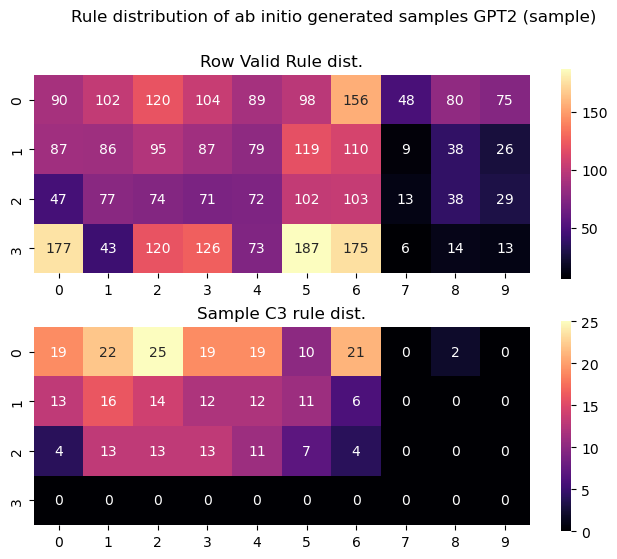

In [ ]:
plt.subplots(2,1, figsize=(8,6))
plt.subplot(2,1,1)
sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Row Valid Rule dist.")
plt.subplot(2,1,2)
sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Sample C3 rule dist.")
plt.suptitle("Rule distribution of ab initio generated samples GPT2 (sample)")

### Ab initio generation with temperature

In [13]:
print("Ab initio generation, sampling: ")
temperature = 0.5
eval_samples_empty = torch.zeros(2048, 81, 3, dtype=th.long).to('cuda')
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_raven, num_mask=81, 
                                            device='cuda', strategy="sample", batch_size=256, temperature=temperature)

Ab initio generation, sampling: 


100%|██████████| 8/8 [01:28<00:00, 11.11s/it]


Completion: C3: 0.168 [344/2048],  valid: 0.526 [3234/6144]


In [16]:
C3_pooled = sum(C3_list, [])
C3_pooled_arr = np.array(C3_pooled)
rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
rule_col_pooled_arr = np.concatenate(rule_col_pooled)
rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
rule_cnt_vec = np.zeros(40).astype(int)
C3_rule_cnt_vec = np.zeros(40).astype(int)
rule_cnt_vec[rule_uniq] = rule_cnt
C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt

Text(0.5, 0.98, 'Rule distribution of ab initio generated samples GPT2 (sample temp=0.5)')

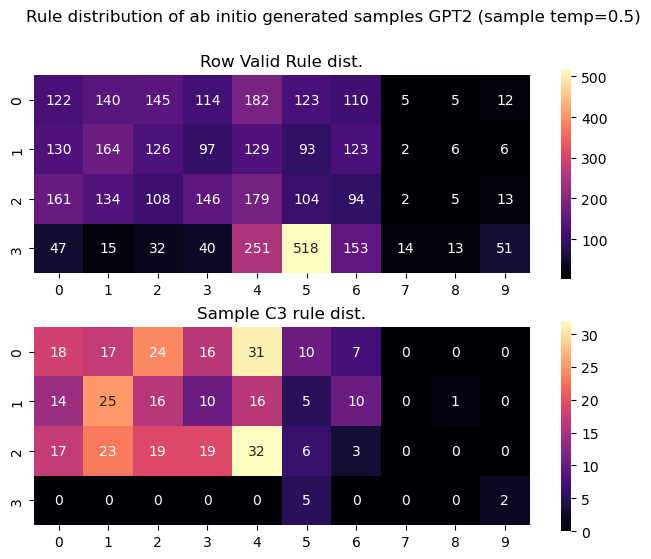

In [17]:
plt.subplots(2,1, figsize=(8,6))
plt.subplot(2,1,1)
sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Row Valid Rule dist.")
plt.subplot(2,1,2)
sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Sample C3 rule dist.")
plt.suptitle(f"Rule distribution of ab initio generated samples GPT2 (sample temp={temperature})")

In [18]:
print("Ab initio generation, sampling: ")
temperature = 0.2
eval_samples_empty = torch.zeros(2048, 81, 3, dtype=th.long).to('cuda')
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_raven, num_mask=81, 
                                            device='cuda', strategy="sample", batch_size=256, temperature=temperature)

Ab initio generation, sampling: 


100%|██████████| 8/8 [01:26<00:00, 10.76s/it]


Completion: C3: 0.304 [622/2048],  valid: 0.727 [4466/6144]


In [19]:
C3_pooled = sum(C3_list, [])
C3_pooled_arr = np.array(C3_pooled)
rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
rule_col_pooled_arr = np.concatenate(rule_col_pooled)
rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
rule_cnt_vec = np.zeros(40).astype(int)
C3_rule_cnt_vec = np.zeros(40).astype(int)
rule_cnt_vec[rule_uniq] = rule_cnt
C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt

Text(0.5, 0.98, 'Rule distribution of ab initio generated samples GPT2 (sample temp=0.2)')

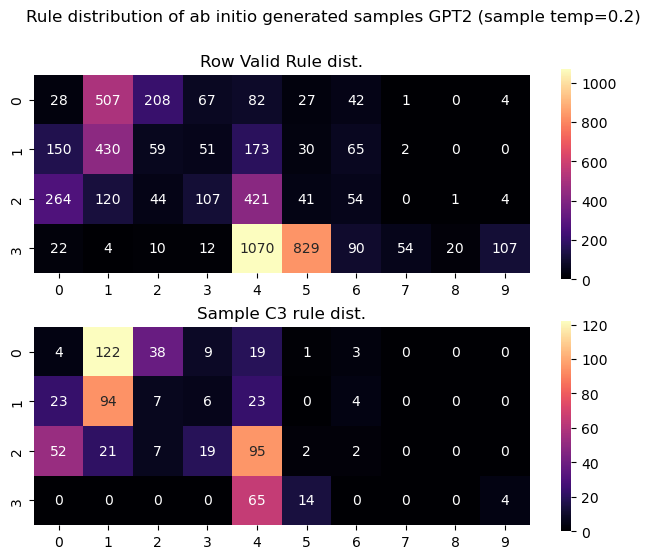

In [20]:
plt.subplots(2,1, figsize=(8,6))
plt.subplot(2,1,1)
sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Row Valid Rule dist.")
plt.subplot(2,1,2)
sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Sample C3 rule dist.")
plt.suptitle(f"Rule distribution of ab initio generated samples GPT2 (sample temp={temperature})")

In [21]:
print("Ab initio generation, sampling: ")
temperature = 0.1
eval_samples_empty = torch.zeros(2048, 81, 3, dtype=th.long).to('cuda')
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_raven, num_mask=81, 
                                            device='cuda', strategy="sample", batch_size=256, temperature=temperature)

Ab initio generation, sampling: 


100%|██████████| 8/8 [01:26<00:00, 10.77s/it]


Completion: C3: 0.400 [820/2048],  valid: 0.818 [5025/6144]


In [24]:
C3_pooled = sum(C3_list, [])
C3_pooled_arr = np.array(C3_pooled)
rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
rule_col_pooled_arr = np.concatenate(rule_col_pooled)
rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
rule_cnt_vec = np.zeros(40).astype(int)
C3_rule_cnt_vec = np.zeros(40).astype(int)
rule_cnt_vec[rule_uniq] = rule_cnt
C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt

Text(0.5, 0.98, 'Rule distribution of ab initio generated samples GPT2 (sample temp=0.1)')

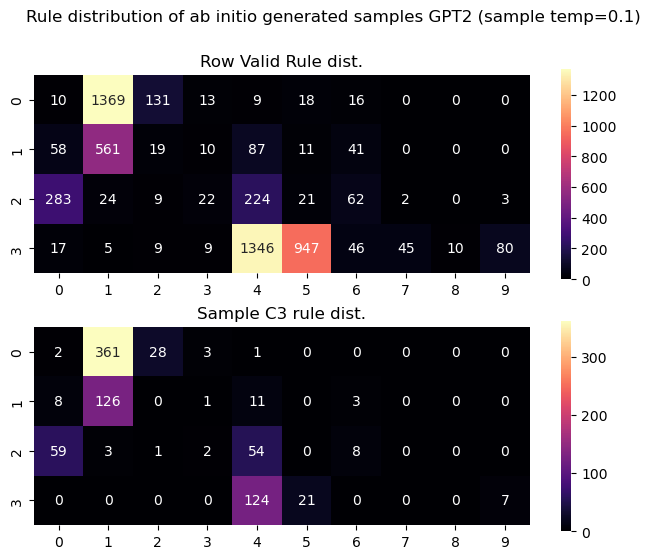

In [25]:
plt.subplots(2,1, figsize=(8,6))
plt.subplot(2,1,1)
sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Row Valid Rule dist.")
plt.subplot(2,1,2)
sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
plt.axis('image')
plt.title("Sample C3 rule dist.")
plt.suptitle(f"Rule distribution of ab initio generated samples GPT2 (sample temp={temperature})")

## Big

In [29]:
gpt2_big_raven = MultiIdxGPT2Model(attribute_dims=(7,10,10), vocab_size=27, max_length=83, n_embd=768, n_class=0, n_layer=24, n_head=12)
gpt2_big_raven.load_state_dict(th.load('/n/home12/binxuwang/Github/DiffusionReasoning/gpt2_Big_raven_fixed.pth'))
gpt2_big_raven.to('cuda').eval()

MultiIdxGPT2Model(
  (sep_word_embed): SepWordEmbed(
    (embedding1): Embedding(8, 256)
    (embedding2): Embedding(11, 256)
    (embedding3): Embedding(11, 256)
  )
  (gpt2): GPT2Model(
    (wte): Embedding(27, 768)
    (wpe): Embedding(83, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (multi_lmhead): SepLMhead(
    (lmhead1): L

In [31]:
th.cuda.empty_cache()

Ab initio generation, sampling: 


100%|██████████| 8/8 [02:52<00:00, 21.57s/it]


Completion: C3: 0.159 [326/2048],  valid: 0.469 [2884/6144]


100%|██████████| 8/8 [02:51<00:00, 21.43s/it]


Completion: C3: 0.183 [375/2048],  valid: 0.538 [3305/6144]


  0%|          | 0/8 [00:01<?, ?it/s]


KeyboardInterrupt: 

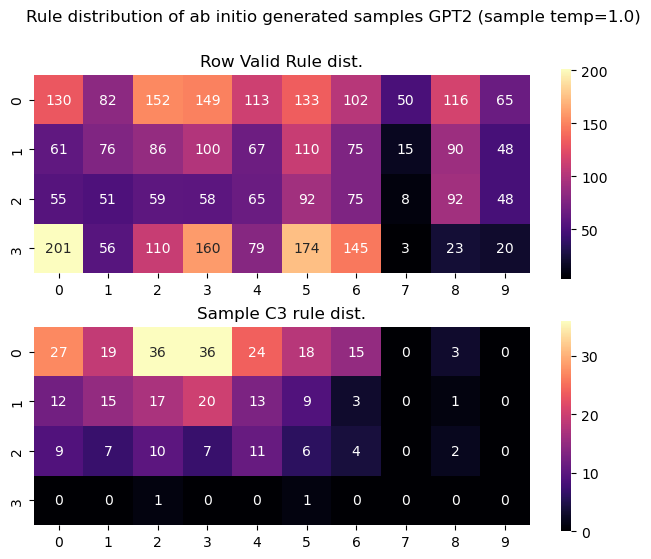

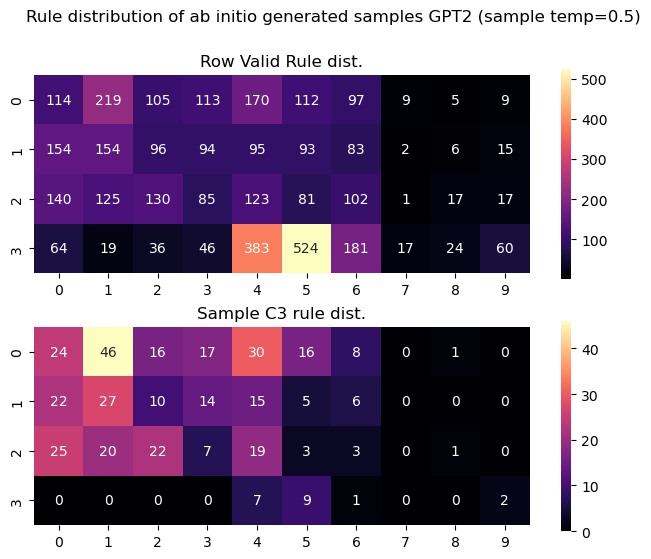

In [30]:
print("Ab initio generation, sampling: ")
temperature = 0.1
for temperature in [1.0, 0.5, 0.2, 0.1]:
    eval_samples_empty = torch.zeros(2048, 81, 3, dtype=th.long).to('cuda')
    eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples_empty, gpt2_big_raven, num_mask=81, 
                                                device='cuda', strategy="sample", batch_size=256, temperature=temperature)
    C3_pooled = sum(C3_list, [])
    C3_pooled_arr = np.array(C3_pooled)
    rule_col_pooled = np.array(rule_col_list, dtype=object).flatten()
    rule_col_pooled = [x for x in rule_col_pooled if len(x) > 0]
    rule_col_pooled_arr = np.concatenate(rule_col_pooled)
    rule_uniq, rule_cnt = np.unique(rule_col_pooled_arr, return_counts=True)
    C3_rule_uniq, C3_rule_cnt = np.unique(C3_pooled_arr, return_counts=True)
    rule_cnt_vec = np.zeros(40).astype(int)
    C3_rule_cnt_vec = np.zeros(40).astype(int)
    rule_cnt_vec[rule_uniq] = rule_cnt
    C3_rule_cnt_vec[C3_rule_uniq] = C3_rule_cnt
    figh,axs = plt.subplots(2,1, figsize=(8,6))
    plt.subplot(2,1,1)
    sns.heatmap(rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
    plt.axis('image')
    plt.title("Row Valid Rule dist.")
    plt.subplot(2,1,2)
    sns.heatmap(C3_rule_cnt_vec.reshape(4,10), annot=True, fmt='d', cmap='magma')
    plt.axis('image')
    plt.title("Sample C3 rule dist.")
    plt.suptitle(f"Rule distribution of ab initio generated samples GPT2 (sample temp={temperature})")
    figh.show()

### Inpainting

In [ ]:
print("Training samples final panel inpainting")
rnd_idx = np.random.choice(len(attr_seq_tsr_train), 512)
gpt2_raven.eval()
eval_samples = attr_seq_tsr_train[rnd_idx,:,:]
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="greedy")

Training samples final panel inpainting
Completion: C3: 407/512,  valid: 1444/1536


In [ ]:
print("Held out samples final panel inpainting")
rnd_idx = np.random.choice(len(attr_seq_tsr_val), 512)
gpt2_raven.eval()
eval_samples = attr_seq_tsr_val[rnd_idx,:,:]
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(eval_samples, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="greedy")

Held out samples final panel inpainting
Completion: C3: 376/512,  valid: 1430/1536


In [ ]:
class_val = torch.tensor([i for i in torch.arange(40) for _ in range(50)],dtype=torch.long)
class_val

tensor([ 0,  0,  0,  ..., 39, 39, 39])

In [ ]:
print("Held out samples final panel inpainting [Greedy decoding]")
gpt2_raven.eval()
eval_complete, C3_list, C2_list, rule_col_list = completion_eval(attr_seq_tsr_val, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="greedy", batch_size=512)

Held out samples final panel inpainting
Completion: C3: 0.739 [1478/2000],  valid: 0.931 [5586/6000]


#### Rule specific analysis

In [ ]:
C3_arr = np.array(C3_list, dtype=object)
df_col = []
for rule in range(40):
    C3_per_rule = C3_arr[class_val == rule]
    # N_C3 = sum([len(x) > 0 for x in C3_per_rule])
    N_C3 = sum([rule in x for x in C3_per_rule])
    N_fail = sum([len(x) == 0 for x in C3_per_rule])
    # print(f"Rule {rule}: N_C3: {N_C3} ")#, N_fail: {N_fail}")
    df_col.append({"rule": rule, "N_C3": N_C3, "N_fail": N_fail, "ratio": N_C3 / len(C3_per_rule)})
df = pd.DataFrame(df_col)
acc_rate_mat = df.ratio.to_numpy().reshape(4,10)


In [ ]:
def get_rule_annot():
    relation_dict = {
    0: "Constant",
    1: "Progression neg 2",
    2: "Progression neg 1",
    3: "Progression pos 1",
    4: "Progression pos 2",
    5: "Arithmetic pos",
    6: "Arithmetic neg",
    7: "XOR",
    8: "OR",
    9: "AND"
    }
    attribute_dict =  {0: "Shape", 1: "Size", 2: "Color", 3: "Number", 4: "Position"}
    rule_table = {}
    for i in range(40):
        if i < 37:
            rule_table[i] = f"{relation_dict[i%10]}-{attribute_dict[i//10]}"
        else:
            rule_table[i] = f"{relation_dict[i%10]}-{attribute_dict[i//10+1]}"
    return rule_table, relation_dict, attribute_dict

rule_table, relation_dict, attribute_dict = get_rule_annot()

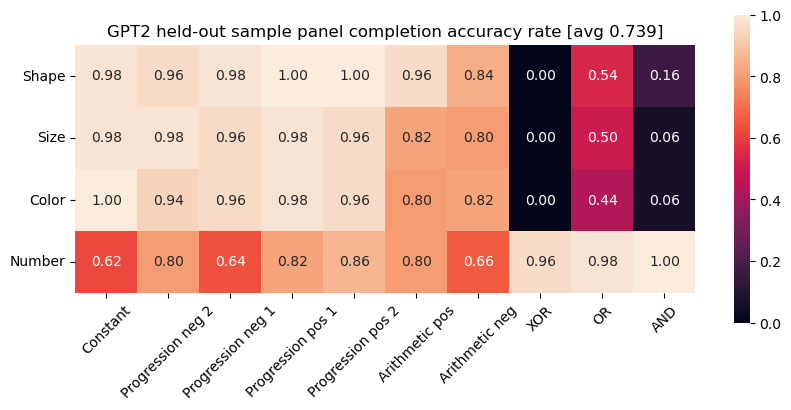

In [ ]:
acc_rate_mat = df.ratio.to_numpy().reshape(4,10)
plt.figure(figsize=(10,4))
sns.heatmap(acc_rate_mat, annot=True, fmt=".2f")
plt.axis("image")
plt.title(f"GPT2 held-out sample panel completion accuracy rate [avg {acc_rate_mat.mean():.3f}]")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
plt.show()

In [ ]:
# count number of total parameters 
total_params = sum(p.numel() for p in gpt2_raven.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 85156638


In [ ]:
85156638 * 20 / 81

21026330.37037037

In [ ]:
print("Held out samples final panel inpainting [Stochastic sampling]")
gpt2_raven.eval()
eval_complete, C3_list_stoch, C2_list, rule_col_list = completion_eval(attr_seq_tsr_val, gpt2_raven, num_mask=9, 
                                                                 device='cuda', strategy="sample", batch_size=512)

Held out samples final panel inpainting
Completion: C3: 0.613 [1225/2000],  valid: 0.900 [5402/6000]


In [ ]:
C3_arr = np.array(C3_list_stoch, dtype=object)
df_col = []
for rule in range(40):
    C3_per_rule = C3_arr[class_val == rule]
    # N_C3 = sum([len(x) > 0 for x in C3_per_rule])
    N_C3 = sum([rule in x for x in C3_per_rule])
    N_fail = sum([len(x) == 0 for x in C3_per_rule])
    # print(f"Rule {rule}: N_C3: {N_C3} ")#, N_fail: {N_fail}")
    df_col.append({"rule": rule, "N_C3": N_C3, "N_fail": N_fail, "ratio": N_C3 / len(C3_per_rule)})
df = pd.DataFrame(df_col)
acc_rate_mat = df.ratio.to_numpy().reshape(4,10)

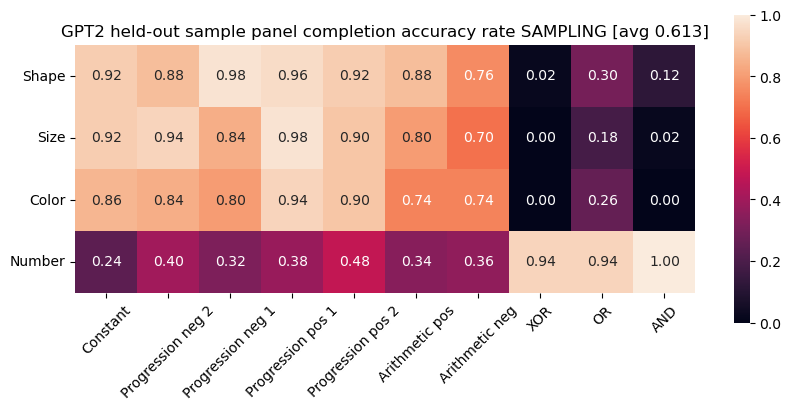

In [ ]:
plt.figure(figsize=(10,4))
sns.heatmap(acc_rate_mat, annot=True, fmt=".2f")
plt.axis("image")
plt.title(f"GPT2 held-out sample panel completion accuracy rate SAMPLING [avg {acc_rate_mat.mean():.3f}]")
plt.xticks(ticks=np.arange(10)+0.5, labels=[relation_dict[i] for i in range(10)], rotation=45)
plt.yticks(ticks=np.arange(4)+0.5, labels=[attribute_dict[i] for i in range(4)], rotation=0)
plt.show()